In [1]:
from pathlib import Path
import tifffile
from matplotlib import pyplot as plt
from skimage import morphology, filters, measure, feature, registration
import numpy as np
import pandas as pd
import math
import miguel_tools as mt
import iTools as iT
import seaborn as sns
import math
from collections import defaultdict
from scipy.spatial import distance
import napari
from skimage import data
from scipy.ndimage import gaussian_laplace
import datetime
# from tqdm.notebook import tqdm
from tqdm import tqdm
from tkinter import filedialog
from tkinter import *
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
napari.__version__ # This actual script works well with '0.3.4'

'0.6.6'

In [ ]:
import numpy as np
import napari

image = np.random.random((10, 256, 256))

with napari.gui_qt():
    viewer = napari.Viewer()
    _ = viewer.add_image(image)
    pts_layer = viewer.add_points(ndim=image.ndim) # This fix the problem of not having by default the dimensions of the image
    print(pts_layer.ndim)
    
print(pts_layer._data)

3
[]


In [3]:
# %gui qt

# from PyQt5.QtWidgets import QFileDialog

# def gui_fname(dir=None):
#     """Select a file via a dialog and return the file name."""
#     if dir is None: dir ='./'
#     fname = QFileDialog.getOpenFileName(None, "Select data file...", 
#                 dir, filter="All files (*);; SM Files (*.sm)")
#     return fname[0]

# def gui_dir(dir=None):
#     """Select a directory path via a dialog and return the path."""
#     if dir is None: dir ='./'
#     dir_name = QFileDialog.getExistingDirectory(None, 'Select a folder:', 'C:\\', QFileDialog.ShowDirsOnly)
#     return dir_name

In [4]:
def ask_folder():
    root = Tk()
    root.withdraw()
    folder_selected = filedialog.askdirectory()
    folder_selected = Path(folder_selected)
    return folder_selected

def ask_file():
    root = Tk()
    root.withdraw()
    file_selected = filedialog.askopenfilename()
    file_selected = Path(file_selected)
    return file_selected

def calculate_shift_with_marker(im, slide):
    with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(im[slide-2:slide+2])
        viewer.add_points(name='point1', face_color='red', opacity=0.9, symbol='square', size=1, n_dimensional=False)
#         viewer.add_points(name='point2', face_color='green', opacity=0.9, symbol='disc', size=1, n_dimensional=False)

    p1, p2 = viewer.layers['point1'].__dict__['_data'][:,1:]
    p1y, p1x = p1[0], p1[1]
    p2y, p2x = p2[0], p2[1]

    manual_shift = [int(round(i)) for i in [p2y - p1y, p2x - p1x]]
    return manual_shift

def calculate_shift(im1, im2):
    shift, error, diffphase = registration.phase_cross_correlation(im1, im2)
#     print(shift, error, diffphase)
    return [int(i) for i in shift]

def shiftIM(im, shift):
    Xshifted = np.roll(im, shift=shift[1], axis=1)
    Yshifted = np.roll(Xshifted, shift=shift[0], axis=0)
    return Yshifted

def registration_checkpoint(im1, im2, shift, savein=None):
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax[0].set_title("Raw")
    ax[0].imshow(im1, alpha=0.5, cmap='Reds')
    ax[0].imshow(im2, alpha=0.5, cmap='Greens')
    
    im2_shifted = shiftIM(im2, shift)
    ax[1].set_title("Shifted")
    ax[1].imshow(im1, alpha=0.5, cmap='Reds')
    ax[1].imshow(im2_shifted, alpha=0.5, cmap='Greens')
    
    for i in ax:
        i.axis('off')
    
    if savein != None:
        plt.savefig(savein, dpi=300, bbox_inches = 'tight')

In [5]:
# folder_jpg = Path(r"D:\TEMP_PICTURES\Lichun\Lichun_Plate1_Full")
# folder_jpg = Path(gui_dir())
folder_jpg = ask_folder()
jpg_paths = sorted(list(folder_jpg.glob("*jpg")))

save_folder = folder_jpg.parent / "{}_results".format(folder_jpg.name)
save_folder.mkdir(exist_ok=True)

# timepoints = [datetime.datetime.strptime(i.stem.rstrip("W"), "%Y%m%d_%H%M%S") for i in jpg_paths]
# timepoints_str = [i.strftime("%m/%d/%Y, %H:%M:%S") for i in timepoints]
timepoints = [i.stem.rstrip("W") for i in jpg_paths]

metadata = {}
metadata['timepoints'] = timepoints

ims = [plt.imread(i)[:, :, 0] for i in tqdm(jpg_paths)] # Reading images in the folder
shapes,  = list(set([i.shape for i in ims]))

 39%|███████████████████████████████▍                                                | 165/420 [00:42<01:05,  3.92it/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Miguel\anaconda3\envs\lichun\lib\site-packages\IPython\core\interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-c9a987adfb58>", line 16, in <module>
    ims = [plt.imread(i)[:, :, 0] for i in tqdm(jpg_paths)] # Reading images in the folder
  File "<ipython-input-5-c9a987adfb58>", line 16, in <listcomp>
    ims = [plt.imread(i)[:, :, 0] for i in tqdm(jpg_paths)] # Reading images in the folder
IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Miguel\anaconda3\envs\lichun\lib\site-packages\IPython\core\interactiveshell.py", line 2054, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another except

TypeError: object of type 'NoneType' has no len()

In [6]:
# Correcting different sizes for the plate, taking an equal dimension square in the center
plate_size = 120 # mm
pixel_plate_dim = (3324, 3312) # Pixel plate dimensions extracted from Image J measurements
min_dim = np.min(pixel_plate_dim)

pixel_size = plate_size/min_dim
print("Plate size: {} mm\n".format(plate_size))
print("Pixel width/height of the plate in the picture: {}\n".format(pixel_plate_dim))
print("Pixel size: {} mm/pixel --> {} um/pixel\n".format(round(pixel_size, 3), round(pixel_size*pow(10, 3), 2)))

heigth = int((shapes[0]-min_dim)/2)
width = int((shapes[1]-min_dim)/2)

metadata['pixel_size_mm'] = pixel_size

imscut = np.stack([i[heigth:heigth+min_dim, width:width+min_dim] for i in tqdm(ims)], axis=0)
# Delete ims variable to free up memory usage
del ims

0.036 mm/pixel --> 36.23 um/pixel


In [7]:
# Correcting rotation and shift

def correct_rotation_and_shift_in_timeseries(plate, rot_from):
    """
    By default shift slide will be taken from rotated image start
    """
#     rot_from = int(input("Choose the slide number where the rotation starts:\t"))
    # rot_from = 119

    # Correcting rotation
    for i in tqdm(range(rot_from, plate.shape[0]), desc="  Rotation from {}".format(rot_from)):
        plate[i] = np.rot90(plate[i], axes=(1,0))

    metadata['slide_rotated'] = rot_from

    shift = calculate_shift(plate[rot_from-1], plate[rot_from]) 

    registration_checkpoint(plate[rot_from-1], 
                            plate[rot_from], 
                            shift=shift,
                            savein=save_folder / "{}_registration_check.png".format(folder_jpg.name))

    # Correcting shift
    shift_from = rot_from
    first_part = np.copy(plate[:shift_from])
    second_part = []
    for i in tqdm(range(shift_from, plate.shape[0])):
        second_part.append(shiftIM(plate[i], shift))

    second_part = np.stack(second_part, axis=0)
    combined = np.concatenate([first_part, second_part], axis=0)
#     plate.shape, combined.shape
    return combined, rot_from

print("Please mark a point in the first slide where rotation starts\n\n")

In [8]:
# Check which slide starts the rotation
with napari.gui_qt():
    viewer = napari.Viewer()
    viewer.add_image(imscut)
    viewer.add_points(name='rotation_slide', face_color='red', opacity=0.9, symbol='disc', size=50, n_dimensional=False)
    viewer.layers['rotation_slide'].mode = 'add'

In [9]:
imscut.shape

(507, 3312, 3312)

In [10]:
rot_from = int(viewer.layers['rotation_slide'].data[0][0])
# rot_from

230

In [11]:
# Full #    20201206_112900W
# 1 #       20201221_182928W

In [12]:
# searchfor = input("Write the name of the 1st rotated slide: ")
# print(searchfor, [i.stem for i in jpg_paths].index(searchfor))

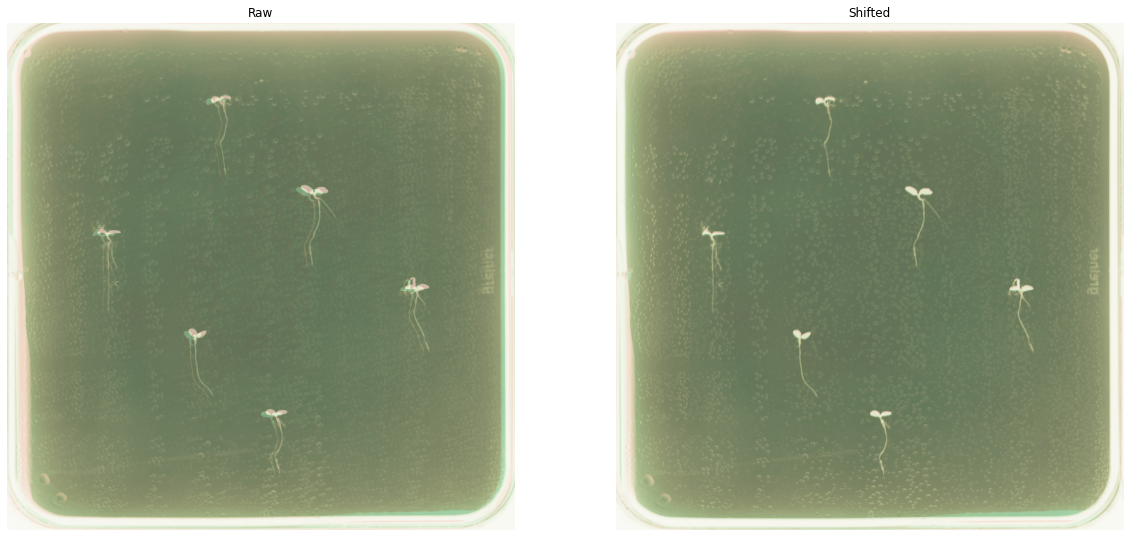

In [13]:
ims_cut_corrected, rot_from = correct_rotation_and_shift_in_timeseries(imscut, rot_from)

In [14]:
# mt.napariView(ims_cut_corrected)

In [15]:
print("Saving Plate rotated and aligned\n")

tifffile.imsave(file=save_folder / "{}_rotated_reg.tif".format(folder_jpg.name), 
                data=np.uint8(ims_cut_corrected), 
                imagej=True,
               metadata=metadata)

C:\Users\Miguel\anaconda3\envs\py38\lib\site-packages\tifffile\tifffile.py:2026: UserWarning: truncating ImageJ file
  warnings.warn('truncating ImageJ file', UserWarning)


# Extracting seedlings

In [16]:
print("Please mark a point in order for seedling, Left-Upper and Right-Lower corner of the seedling to extract: ")

with napari.gui_qt():
    viewer = napari.Viewer()
    viewer.add_image(ims_cut_corrected[-1])
    viewer.add_points(name='plants', face_color='red', opacity=0.9, symbol='disc', size=50, n_dimensional=False)
    viewer.layers['plants'].mode = 'add'

In [17]:
coordinates = viewer.layers['plants'].data
coordinates = coordinates.astype(int)
coordinates = mt.sublist(list(coordinates), 2)

seedling_names = ["seedling_{}".format(i+1) for i in range(len(coordinates))]
print("Extracting:\n")
mt.print_pretty_list(seedling_names)
print("\n")

plants_separated = []
for coord in tqdm(coordinates):
    y1, x1 = coord[0]
    y2, x2 = coord[1]
    plant_cut = imscut[:, y1:y2, x1:x2]
    plants_separated.append(plant_cut)
    del plant_cut

['seedling_1', 'seedling_2', 'seedling_3', 'seedling_4', 'seedling_5', 'seedling_6']


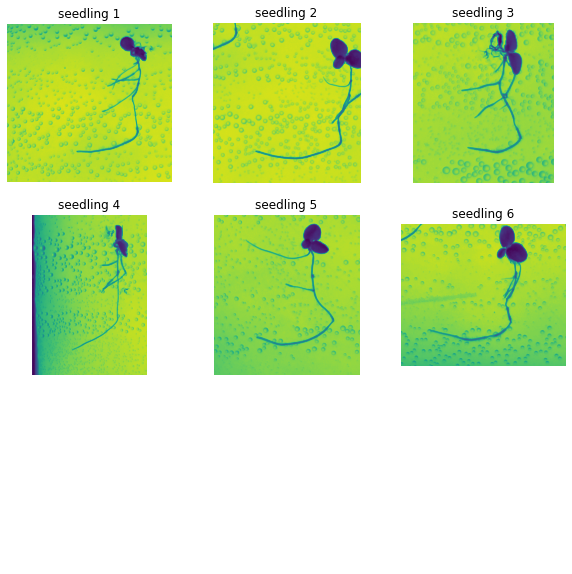

In [18]:
print("Saving Tile of seedlings extracted\n")
n = math.ceil(np.sqrt(len(plants_separated)))
fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(10,10))
ax = ax.ravel()
for ix, i in enumerate(ax):
    try:
        i.imshow(plants_separated[ix][-1])
        i.axis('off')
        i.set_title("seedling {}".format(ix+1))
    except:
        i.axis('off')
        
plt.savefig(save_folder / "{}_seedlings_extracted.png".format(folder_jpg.name), dpi=300, bbox_inches = 'tight')    

In [19]:
# Realigment of each plant separated


shift_from = rot_from
plants_separated_aligned = []



for ix, each_plant in enumerate(tqdm(plants_separated, desc="Realigment of each seedling")):
#     shift_from = 119
    first_part = each_plant[:shift_from]
    second_part = []
    
    im1, im2 = each_plant[shift_from-1], each_plant[shift_from]
    shift_value = calculate_shift(im1[200:, 200:], im2[200:, 200:]) # Trimming the borders to avoid wrong alignment
    for sl in range(shift_from, each_plant.shape[0]):
        second_part.append(shiftIM(each_plant[sl], shift_value))
    second_part = np.stack(second_part, axis=0)
    plant_combined = np.concatenate([first_part, second_part], axis=0)
    plants_separated_aligned.append(plant_combined)
    
# del plants_separated

# Saving seedling extracted and including metadata
for ix, i in enumerate(tqdm(plants_separated_aligned, desc="Saving seedlings tifs")):
    meta_plant = metadata.copy()
    meta_plant['seedling'] = seedling_names[ix]
    
    pl = plants_separated_aligned[ix]
#     plant_highlithed = filters.sobel(pl)
#     plant_highlithed_rot = np.rot90(plant_highlithed, axes=(1,2))
    
    tifffile.imsave(file=save_folder / "{}_seedling_{}.tif".format(folder_jpg.name, ix+1), 
                    data=np.uint8(pl), 
                    imagej=True,
                   metadata=metadata)

In [ ]:
print("A new window has been opened, press Toggle grid view and check \nif the seedlings extracted are well extracted and aligned")

In [20]:
mt.napariView(plants_separated_aligned)